In [1]:
import pandas as pd
import os
import csv
import re
import sys
import numpy as np
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score

logging.getLogger('numba').setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True

In [2]:
# Function to extract the numeric part of the filename (after the last underscore and before the file extension)
def extract_numeric_part(path):
    # This regex extracts the number after the last underscore and before the file extension (.flac)
    match = re.search(r'_(\d+)\.flac$', path)
    if match:
        return match.group(1)  # Return only the numeric part
    return None  # Return None if the pattern doesn't match

def extract_numeric_part_npy(path):
    # This regex extracts the number after the last underscore and before the file extension (.flac)
    match = re.search(r'_E_(\d+)_None\.npy$', path)
    if match:
        return match.group(1)  # Return only the numeric part
    return None  # Return None if the pattern doesn't match


def pred_and_labels_clean(file1_csv, file2_csv, feature):
    '''
    file1: probabilities list .csv
    file2: eval dataset .csv
    '''
    
    prediction_list = []
    label_list = []
    pred_class1_list = []
    
    # Step 1: Read file2 into a dictionary for quick look-up based on the numeric part of the file path
    file2_dict = {}
    with open(file2_csv, mode='r') as file2:
        reader = csv.DictReader(file2)
        for row in reader:
            numeric_file2 = extract_numeric_part(row['path'])
            if numeric_file2:
                file2_dict[numeric_file2] = row['label']

    # Step 2: Traverse file1 and check against file2 dictionary, using tqdm for progress tracking
    with open(file1_csv, mode='r') as file1:
        reader = csv.DictReader(file1)
        total_rows = sum(1 for _ in open(file1_csv)) - 1  # Calculate total rows for the progress bar (excluding header)
    
        file1.seek(0)  # Reset the reader position back to the start of the file after counting
        if feature == 'audio':
            for row in reader:
                # Extract the numeric part from file1's path
                file1_path = row['Filename']
                numeric_file1 = extract_numeric_part(file1_path)
        
                # Step 3: Check if the numeric part exists in the file2 dictionary
                if numeric_file1 and numeric_file1 in file2_dict:
                    pred_class_0 = float(row['Pred.class 0'])
                    pred_class_1 = float(row['Pred.class 1'])
            
                    # Step 4: Append prediction based on comparison
                    prediction_list.append(0 if pred_class_0 > pred_class_1 else 1)
            
                    # Step 5: Append the corresponding label from file2
                    label_list.append(int(file2_dict[numeric_file1]))
                
                    # Step 6:  Append Pred.class 1 value to the new list
                    pred_class1_list.append(pred_class_1)
        elif feature == 'spec':
            for row in reader:
                # Extract the numeric part from file1's path
                file1_path = row['Filename']
                numeric_file1 = extract_numeric_part_npy(file1_path)
        
                # Step 3: Check if the numeric part exists in the file2 dictionary
                if numeric_file1 and numeric_file1 in file2_dict:
                    pred_class_0 = float(row['Pred.class 0'])
                    pred_class_1 = float(row['Pred.class 1'])
            
                    # Step 4: Append prediction based on comparison
                    prediction_list.append(0 if pred_class_0 > pred_class_1 else 1)
            
                    # Step 5: Append the corresponding label from file2
                    label_list.append(int(file2_dict[numeric_file1]))
                
                    # Step 6:  Append Pred.class 1 value to the new list
                    pred_class1_list.append(pred_class_1)
    
    return prediction_list, label_list, pred_class1_list




def pred_and_labels_attack(file1_csv, file2_csv):
    
    def extract_numeric_part(path):
        # This regex captures the numeric part following 'LA_E_' and stops at the next underscore or period
        match = re.search(r'LA_E_(\d+)', path)
        if match:
            return match.group(1)  # Return only the numeric part
        return None  # Return None if the pattern doesn't match
    
    prediction_list = []
    label_list = []
    pred_class1_list = []
    
    # Step 1: Read file2 into a dictionary for quick look-up based on the numeric part of the file path
    file2_dict = {}
    with open(file2_csv, mode='r') as file2:
        reader = csv.DictReader(file2)
        for row in reader:
            numeric_file2 = extract_numeric_part(row['path'])
            if numeric_file2:
                file2_dict[numeric_file2] = row['label']

    # Step 2: Traverse file1 and check against file2 dictionary, using tqdm for progress tracking
    with open(file1_csv, mode='r') as file1:
        reader = csv.DictReader(file1)
        total_rows = sum(1 for _ in open(file1_csv)) - 1  # Calculate total rows for the progress bar (excluding header)
    
        file1.seek(0)  # Reset the reader position back to the start of the file after counting
        for row in reader:
            # Extract the numeric part from file1's path
            file1_path = row['Filename']
            numeric_file1 = extract_numeric_part(file1_path)
        
            # Step 3: Check if the numeric part exists in the file2 dictionary
            if numeric_file1 and numeric_file1 in file2_dict:
                pred_class_0 = float(row['Pred.class 0'])
                pred_class_1 = float(row['Pred.class 1'])
            
                # Step 4: Append prediction based on comparison
                prediction_list.append(0 if pred_class_0 > pred_class_1 else 1)
            
                # Step 5: Append the corresponding label from file2
                label_list.append(int(file2_dict[numeric_file1]))
                
                # Step 6:  Append Pred.class 1 value to the new list
                pred_class1_list.append(pred_class_1)

    
    return prediction_list, label_list, pred_class1_list

In [3]:
def PR(attack, attack_model, epsilon, eval_model, model_version, dataset, type_of_spec, feature, q_1=None, q_2=None, q_3=None, eps1=None, eps2=None, eps3=None, trip=0):
   
    epsilon_str = str(epsilon).replace('.', 'dot')
    eps1_str = str(eps1).replace('.', 'dot')
    eps2_str = str(eps2).replace('.', 'dot')
    eps3_str = str(eps3).replace('.', 'dot')
    
    script_dir = os.getcwd()
    probs_csv_c = f'probs_{eval_model}_{model_version}_clean_{dataset}_{type_of_spec}_{feature}.csv'
    
    if attack != 'Ens1D' and attack != 'Ens2D':
        probs_csv_p = f'probs_{eval_model}_{model_version}_{attack}_{attack_model}_{dataset}_{epsilon_str}_{type_of_spec}_{feature}.csv'
    elif attack == 'Ens1D' and trip==0:
        probs_csv_p = f'probs_{eval_model}_{model_version}_Ens1D_{attack_model}_{q_1}_{q_2}_{eps1_str}_{eps2_str}_{type_of_spec}_{feature}.csv'
    elif attack == 'Ens1D' and trip==1:
        probs_csv_p = f'probs_{eval_model}_{model_version}_Ens1D_{attack_model}_{q_1}_{q_2}_{q_3}_{eps1_str}_{eps2_str}_{eps3_str}_{type_of_spec}_{feature}.csv'
    elif attack == 'Ens2D':
        sys.exit('TODO 2D ens')  
        
    if dataset == '3s' and trip == 0:
        eval_csv = os.path.join(os.path.dirname(script_dir), 'data', 'df_eval_19_3s.csv' )
    elif dataset == 'whole' and trip == 0:
        eval_csv = os.path.join(os.path.dirname(script_dir), 'data', 'df_eval_19.csv' )
    elif dataset == 'whole' and trip == 1:
        eval_csv = os.path.join(os.path.dirname(script_dir), 'data', 'df_eval_19_reduced.csv' )
    
    # get GT labels
    pred_list_c, labels_list_c, pred_1_c = pred_and_labels_clean(file1_csv=probs_csv_c, file2_csv=eval_csv, feature=feature)
    labels_c = np.array(labels_list_c)
    pred_1_c = np.array(pred_1_c)
    
    pred_list_p, labels_list_p, pred_1_p = pred_and_labels_attack(file1_csv=probs_csv_p, file2_csv=eval_csv)
    labels_p = np.array(labels_list_p)
    pred_1_p = np.array(pred_1_p)
    
    if len(pred_list_c) != len(pred_list_p):
        sys.exit(f'length of clean is {len(pred_list_c)}, length of pert is {len(pred_list_p)}')
    
    # CLEAN - compute PR curve, PR AUC, and F1 score
    precision_c, recall_c, _ = precision_recall_curve(labels_c, pred_1_c)
    pr_auc_c = auc(recall_c, precision_c)
    f1_c = f1_score(labels_c, pred_1_c > 0.5)
    
    # PERTURBED - compute PR curve, PR AUC, and F1 score
    precision_p, recall_p, _ = precision_recall_curve(labels_p, pred_1_p)
    pr_auc_p = auc(recall_p, precision_p)
    f1_p = f1_score(labels_p, pred_1_p > 0.5)
    
    plt.subplot(1, 2, 2)
    plt.plot(recall_c, precision_c, color='darkorange', lw=1.5, label='Clean PR (AUC={:.2f})'.format(pr_auc_c))
    plt.plot(recall_p, precision_p, color='red', lw=1.5, label='Perturbed PR (AUC={:.2f})'.format(pr_auc_p))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower right')
    plt.title('Precision-Recall Curve')
    plt.tight_layout()
    plt.show()
    


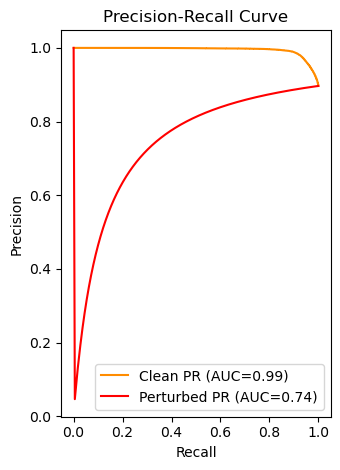

In [6]:
PR(attack='BIM', attack_model='ResNet2D', epsilon=3.0, eval_model='ResNet2D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)